# Running External Programs

Sometimes, your code needs to interact with programs in the outside world, be it the
operating system in which it runs or other languages such as C or Fortran. This chapter
shows how straightforward it is to run external programs from Julia and covers the
following topics:

- Running shell commands—interpolation and pipelining
- Calling C and Fortran
- Calling Python
- Performance tips

# Running shell commands

To interact with the operating system from within the Julia REPL, there are a few helper
functions available, as follows:

pwd(): this function prints the current directory, for example, "d:\\test"

In [4]:
pwd()

"/home/javid/julia/Practice/Chapter09"

cd("d:\\test\\week1"): this function helps to navigate to subdirectories

In [5]:
cd("..")

In [6]:
pwd()

"/home/javid/julia/Practice"

In [7]:
cd("Chapter09/")

In [8]:
pwd()

"/home/javid/julia/Practice/Chapter09"

;: in the interactive shell, you can also use shell mode using the ; modifier, for
example: ; cd folder: navigates to folder

However, what if you want to run a shell command by using the operating system (the
OS)? Julia offers efficient shell integration through the run function, which takes an object
of type Cmd, defined by enclosing a command string in backticks (``).

In [9]:
cmd = `echo what the heck is going on here`

`echo what the heck is going on here`

In [10]:
run(cmd)

what the heck is going on here


Process(`echo what the heck is going on here`, ProcessExited(0))

Be careful to enclose the command text in backticks (`), not single quotes
(').

If the execution of cmd by the OS goes wrong, run throws a failed process error. You
might want to test the command first before running it; success(cmd) will return true if
it executes successfully, otherwise it returns false.

In [11]:
success(cmd)

true

Julia forks commands as child processes from the Julia process. Instead of immediately
running the command in the shell, backticks create a Cmd object to represent the command.
This can then be run, connected to other commands via pipes, and read or written to.

# Interpolation

String interpolation with the $ operator is allowed in a command object, like this:

In [12]:
filename = "WTF.txt"
cmd = `touch $filename`
run(cmd)

Process(`touch WTF.txt`, ProcessExited(0))

# Pipelining

Julia defines a pipeline function to redirect the output of a command as the input to the
following command:

In [19]:
run(pipeline(`ls -l /home/javid`, `grep ml`))

drwxr-xr-x 1 javid javid        230 Dec 28 17:59 ml
-rwxrwxrwx 1 javid javid  955354624 Nov  7 00:43 ml.tar


Base.ProcessChain(Base.Process[Process(`ls -l /home/javid`, ProcessExited(0)), Process(`grep ml`, ProcessExited(0))], Base.DevNull(), Base.DevNull(), Base.DevNull())

WTF WTF WTF

To capture the result of a command in Julia, use read or readline:

In [33]:
result = read(run(`ls`))

Untitled.ipynb
WTF.txt


UInt8[]

In [34]:
typeof(result)

Vector{UInt8} (alias for Array{UInt8, 1})

In [35]:
result

UInt8[]

In [36]:
islinux()

LoadError: UndefVarError: islinux not defined

Using this functionality requires careful testing, and, probably, the code will differ
according to the operating system on which your Julia program runs. You can obtain the
OS from the variable Sys.KERNEL

In [38]:
Sys.KERNEL

:Linux

In [40]:
Sys.islinux()

true

# Calling C and Fortran

While Julia can rightfully claim to obviate the need to write some C or Fortran code, it is
possible that you will need to interact with the existing C or Fortran shared libraries.
Functions in such a library can be called directly by Julia, with no glue code, boilerplate
code, or compilation needed. Because Julia's LLVM compiler generates native code, calling
a C function from Julia has exactly the same overhead as calling the same function from C
code itself.

- For calling out to C, we need to work with pointer types; a native pointer Ptr{T}
is nothing more than the memory address for a variable of type T. You can use
Cstring if the value is null-terminated.

- At this lower level, the term primitive is also used. primitive is a concrete
type whose data consists of bits, such as Int8, UInt8, Int32, Float64, Bool,
and Char.

- To pass a string to C, it is converted to a contiguous byte array representation
with the function unsafe_string(); given Ptr to a C string, it returns a Julia
string.

Here is how to call a C function in a shared library (calling Fortran is done similarly).
Suppose we want to know the value of an environment variable in our system, say, the
language; we can obtain this by calling the C function getenv from the shared library
libc:

In [45]:
lang = ccall( (:getenv, "libc"), Cstring, (Cstring,), "LANG")

LoadError: could not load library "libc"
/usr/lib/libc.so: invalid ELF header

ccall takes the following arguments:

- A (:function, "library") tuple, where the name of the C function (here,
getenv) is used as a symbol, and the library name (here, libc) as a string

- The return type (here, Cstring), which can also be any primitive, or Ptr

- A Cstring as input arguments: note the tuple notation (Cstring,)

- The actual arguments, if there are any (here, "LANG")

It is generally advisable to test for the existence of a library before doing the call. This can
be tested like this: find_library(["libc"]), which returns "libc" when the library is
found, or " " when it cannot find the library.

Arguments to C
functions are, in general, automatically converted, and the returned values in C types are
also converted to Julia types. Arrays of Booleans are handled differently in C and Julia and
cannot be passed directly, so they must be manually converted. The same applies for some
system-dependent types.

The ccall function will also automatically ensure that all of its arguments will be
preserved from garbage collection until the call returns. C types are mapped to Julia types.
For example, short is mapped to Int16, and double to Float64.

If you have the existing C code, you must compile it as a shared library to call it from Julia.
With GCC, you can do this using the -shared -fPIC command-line arguments. Support
for C++ is more limited and is provided by the Cpp and Clang packages.

# Calling Python

In [1]:
using PyCall

In [7]:
using PyPlot

In [3]:
@pyimport cv2

In [4]:
img = cv2.imread("../../../earth.jpg", 0);

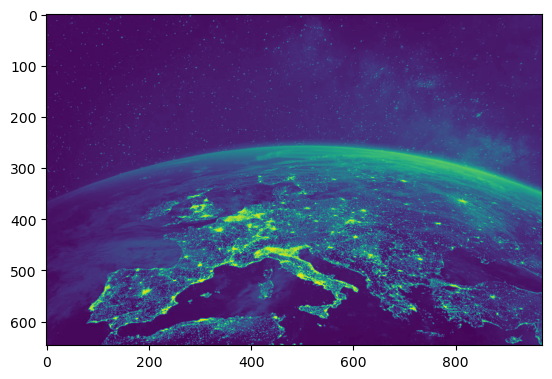

PyObject <matplotlib.image.AxesImage object at 0x7f1ff1d25520>

In [9]:
plt.imshow(img)

In [11]:
@pyimport tensorflow as tf

2021-12-30 23:29:41.694939: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/javid/anaconda3/envs/tensorflow/lib/python3.8/site-packages/cv2/../../lib64:
2021-12-30 23:29:41.694956: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Performance tips

- Refrain from using global variables. If unavoidable, make them constant with
const, or at least annotate the types. It is better to use local variables instead;
they are often only kept on the stack (or even in registers), especially if they are
immutable.

- Use a main() function to structure your code.

- Use functions that do their work on local variables via function arguments, rather
than mutating global objects.

* Type stability is very important:
    - Avoid changing the types of variables over time
    - The return type of a function should only depend on the type of
the arguments

Even if you do not know the types that will be used in a function, but you do
know it will always be of the same type T, then functions s

In [13]:
# <!-- function myFunc(a::T, c::Int) where T
# # code
# end -->

- If large arrays or dictionaries are needed, indicate their final size with
sizehint! from the start (refer to the Ranges and arrays section of Chapter 2,
Variables, Types, and Operations).

- If arr is a very large array that you no longer need, you can free the memory it
occupies by setting arr = nothing. The occupied memory will be released the
next time the garbage collector runs. You can force this to happen by invoking
GC.gc().

- In certain cases (such as real-time applications), disabling garbage collection
(temporarily) with GC.enable(false) can be useful.

- Use named functions instead of anonymous functions.

- In general, use small functions.

- Don't test for the types of arguments inside a function, use an argument type
annotation instead.

- If necessary, code different versions of a function (several methods) according to
the types, so that multiple dispatch applies. Normally, this won't be necessary,
because the JIT compiler is optimized to deal with types as they come.

- Use types for keyword arguments; avoid using the splat operator (...) for
dynamic lists of keyword arguments.

- Using mutating APIs (functions with ! at the end) is helpful, for example, to
avoid copying large arrays.

- Prefer array operations to comprehensions, for example, x.^2 is considerably
faster than [val^2 for val in x].

- Don't use try/catch in the inner loop of a calculation.

- Use immutable types (cfr. package ImmutableArrays).

- Avoid using type Any, especially in collection types.

- Avoid using abstract types in a collection

- Type annotate fields in composite types.

- Avoid using a large number of variables, large temporary arrays, and collections,
because this provokes a great deal of garbage collection. Also, don't make copies
of variables if you don't have to.

- Avoid using string interpolation ($) when writing to a file, just write the values.

- Devectorize your code, that is, use explicit for loops on array elements instead of
simply working with the arrays and matrices. (This is the exact opposite of
advice commonly given to R, MATLAB, or Python users.)

- If appropriate, use a parallel reducing form with @distributed instead of a
normal for loop

- Reduce data movement between workers in a parallel execution as much as
possible

- Fix deprecation warnings.

- Use the macro @inbounds so that no array bounds checking occurs in
expressions (if you are absolutely certain that no BoundsError occurs!).

- Avoid using eval at runtime.

In [14]:
quote 
    b = 29
    sin(b)
end


quote
    #= In[14]:2 =#
    b = 29
    #= In[14]:3 =#
    sin(b)
end

In [15]:
eval(ans)

-0.6636338842129675

In general, split your code into functions. Data types will be determined at function calls,
and when a function returns. Types that are not supplied will be inferred, but the Any type
does not translate to efficient code. If types are stable (that is, variables stick to the same
type) and can be inferred, then your code will run quickly.

# Tools to use

Execute a function with certain parameter values, and then use @time (refer to the Generic
functions and multiple dispatch section in Chapter 3, Functions) to measure the elapsed time
and memory allocation. If too much memory is allocated, investigate the code for type
problems.

A profiler tool is available in the standard library to measure the performance of your
running code and identify possible bottleneck lines. This works through calling your code
with the @profile macro (refer to

BenchmarkingTools is an excellent package with macros and tools for benchmarking your
code.
For more tips, examples, and argumentation about performance, look up
http://docs.julialang.org/en/latest/manual/performance-tips/.